# Project title: Diabet Prediction [notebook 'Diabet_Prediction_Models']

## Authors: Denys Herasymuk & Yaroslav Morozevych

## Contents of This Notebook

Click on the section and go to this cell immediately. (works only with Jupyter in browser)

* [Section 1. Explore Data](#section_1)
* [Section 2. Train and Validate Models](#section_2)
* [Section 3. Test Set Evaluation](#section_3)

When you use `Run All` button with this notebook, you should wait approx. 3-5 mins to get output of all cells.

**How to run this notebook**

* Create a new virtual env with python 3.8
* In terminal run  -- `pip install -r requirements.txt`

## General Configuration

In [1]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

import os
import sys
import math
import pickle
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgbm
import tensorflow as tf
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy
from utils import scale_normalize

from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2022-01-16 21:11:55.258586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-16 21:11:55.258619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


In [3]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn
#
# from warnings import simplefilter
# # ignore all future warnings
# from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
# simplefilter(action='ignore', category=ConvergenceWarning)
# simplefilter(action='ignore', category=DataConversionWarning)
#
# warnings.filterwarnings('ignore', category=ConvergenceWarning, append=True)
# warnings.filterwarnings('ignore', category=DataConversionWarning, append=True)
#
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

os.environ["PYTHONWARNINGS"] = "ignore"
# sys.stderr = -1

# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# from warnings import simplefilter
# from sklearn.exceptions import ConvergenceWarning
# simplefilter("ignore", category=ConvergenceWarning)

In [4]:
warnings.warn("deprecated", DeprecationWarning)

## Python & Library Versions

In [5]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             ("tensorflow", tf.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.5
seaborn     0.11.2
sklearn     1.0.1
tensorflow  2.7.0


<a id='section_1'></a>

## Section 1. Explore Data

### Pima Indians dataset

In [6]:
# laod dataset with removed record with incorrect values in "BMI", "SkinThickness" & "BloodPressure" columns
diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_cleaned.csv"))
diabetes_df = diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [7]:
diabetes_df.head()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
0,6,148,35,0,33.6,0.627,50,1.880,1
1,1,85,29,0,26.6,0.351,31,0.882,0
2,1,89,23,94,28.1,0.167,21,0.240,0
3,0,137,35,168,43.1,2.288,33,1.870,1
4,3,78,32,88,31.0,0.248,26,0.240,1


### Validate Data

In [8]:
diabetes_df.describe()

,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.510242,119.903166,29.186220,113.960894,32.890130,0.501823,31.586592,0.957773,0.333333
std,3.304281,32.975142,10.505807,122.894735,6.875842,0.343643,10.747286,0.528672,0.471844
min,0.000000,0.000000,7.000000,0.000000,18.200000,0.085000,21.000000,0.000000,0.000000
25%,1.000000,97.000000,22.000000,0.000000,27.800000,0.259000,23.000000,0.552000,0.000000
50%,2.000000,115.000000,29.000000,90.000000,32.800000,0.415000,28.000000,0.878000,0.000000
75%,5.000000,141.000000,36.000000,165.000000,36.900000,0.658000,38.000000,1.328000,1.000000
max,17.000000,199.000000,99.000000,846.000000,67.100000,2.420000,81.000000,2.110000,1.000000


In [9]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
DiabetesRisk                0
Outcome                     0
dtype: int64

In [10]:
# Selecting duplicate rows except first.
# Occurrence based on all columns
duplicates = diabetes_df[diabetes_df.duplicated()]

print("Duplicate rows :")
duplicates

Duplicate rows :


,Pregnancies,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome


### Ranchi-835215 dataset

In [11]:
ranchi_diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_2019_processed.csv"))
ranchi_diabetes_df = ranchi_diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [12]:
ranchi_diabetes_df.head()

,Age,Family_Diabetes,highBP,BMI,RegularMedicine,Stress,BPLevel,Pregancies,Diabetic
0,2,0,1,39.0,0.0,1,1.0,0.0,0.0
1,2,0,1,28.0,1.0,1,0.0,0.0,0.0
2,1,0,0,24.0,0.0,1,0.0,0.0,0.0
3,2,0,0,23.0,0.0,1,0.0,0.0,0.0
4,1,0,0,27.0,0.0,1,0.0,0.0,0.0


### Validate Data

In [13]:
ranchi_diabetes_df.describe()

,Age,Family_Diabetes,highBP,BMI,RegularMedicine,Stress,BPLevel,Pregancies,Diabetic
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.970067,0.480044,0.242794,25.537694,0.358093,1.221729,0.292683,0.385809,0.291574
std,1.141582,0.499879,0.429009,5.274509,0.479706,0.807604,0.516897,0.909768,0.454739
min,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,22.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,24.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,0.000000,28.000000,1.000000,2.000000,1.000000,0.000000,1.000000
max,3.000000,1.000000,1.000000,45.000000,1.000000,3.000000,2.000000,4.000000,1.000000


In [14]:
ranchi_diabetes_df.isnull().sum()

Age                0
Family_Diabetes    0
highBP             0
BMI                0
RegularMedicine    0
Stress             0
BPLevel            0
Pregancies         0
Diabetic           0
dtype: int64

<a id='section_2'></a>

## Section 2. Dataframe Balancing & Split dataframe on features and target

### Pima Indians dataset

In [15]:
# choose the most relevant features based on data analysis in 01_Process_Data_and_EDA.ipynb
features = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
scaled_df = scale_normalize(df=diabetes_df, features=features)

In [16]:
# separate the dataframe onto features and target
features_df = scaled_df.drop("Outcome", axis="columns")
target_df = diabetes_df[['Outcome']]

In [17]:
SEED = 25
n_folds = 3

# split the data on test and train
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
samples_per_fold = len(y_test)
X_train.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.026907,-0.015174,-0.000175,-0.023233,0.003571,0.010063,0.005302
std,1.018347,0.969375,0.982606,0.981235,0.990420,1.000519,1.002535
min,-1.063322,-3.639559,-0.928170,-2.138477,-1.214084,-0.985966,-1.813348
25%,-0.760402,-0.664852,-0.928170,-0.740982,-0.716011,-0.706566,-0.768248
50%,-0.457482,-0.179186,-0.178863,-0.013120,-0.247065,-0.334032,-0.151034
75%,0.754197,0.610022,0.431984,0.569169,0.498588,0.597303,0.700950
max,4.086316,2.400917,5.131437,3.553402,5.322033,4.602044,2.181508


#### Random over-sampling with imblearn

In [18]:
# analyse value proportions
target_df.value_counts()

Outcome
0          358
1          179
dtype: int64

In [19]:
y_train.value_counts()

Outcome
0          291
1          138
dtype: int64

In [20]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=SEED)

# fit predictor and target variable
ros_X_train, ros_y_train = ros.fit_resample(X_train, y_train)

print('Original dataset shape', len(y_train))
print('Resample dataset shape', len(ros_y_train))
ros_y_train.value_counts()

Original dataset shape 429
Resample dataset shape 582


Outcome
0          291
1          291
dtype: int64

#### Synthetic Minority Oversampling Technique (SMOTE)

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)

# fit predictor and target variable
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

print('Original dataset shape', len(y_train))
print('Resample dataset shape', len(smote_y_train))
smote_y_train.value_counts()

Original dataset shape 429
Resample dataset shape 582


Outcome
0          291
1          291
dtype: int64

### Ranchi-835215 dataset

In [22]:
# choose the most relevant features
features = ["Age", "Family_Diabetes", "highBP", "BMI", "RegularMedicine", "Stress", "BPLevel", "Pregancies", "Diabetic"]
scaled_df = scale_normalize(df=ranchi_diabetes_df, features=features)

# separate the dataframe onto features and target
ranchi_features_df = scaled_df.drop("Diabetic", axis="columns")
ranchi_target_df = ranchi_diabetes_df[['Diabetic']]

# split the data on test and train
ranchi_X_train, ranchi_X_test, ranchi_y_train, ranchi_y_test = train_test_split(ranchi_features_df, ranchi_target_df, test_size=0.2, random_state=SEED)
ranchi__samples_per_fold = len(ranchi_y_test)
ranchi_X_train.describe()

,Age,Family_Diabetes,highBP,BMI,RegularMedicine,Stress,BPLevel,Pregancies
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,-0.017527,0.008018,-0.013115,-0.007282,-0.012107,-0.016955,-0.010804,-0.035341
std,0.990853,1.000982,0.992704,1.003187,0.997028,1.008187,0.998468,0.972357
min,-0.850228,-0.960854,-0.566255,-1.998962,-0.746899,-1.513622,-0.566544,-0.424309
25%,-0.850228,-0.960854,-0.566255,-0.671087,-0.746899,-0.274705,-0.566544,-0.424309
50%,-0.850228,-0.960854,-0.566255,-0.291695,-0.746899,-0.274705,-0.566544,-0.424309
75%,0.902699,1.040741,-0.566255,0.467090,1.338869,0.964213,1.369149,-0.424309
max,1.779162,1.040741,1.765990,3.691927,1.338869,2.203130,3.304843,3.974853


#### Random over-sampling with imblearn

In [23]:
# analyse value proportions
ranchi_target_df.value_counts()

Diabetic
0.0         639
1.0         263
dtype: int64

In [24]:
ranchi_y_train.value_counts()

Diabetic
0.0         513
1.0         208
dtype: int64

In [25]:
# fit predictor and target variable
ros_ranchi_X_train, ros_ranchi_y_train = ros.fit_resample(ranchi_X_train, ranchi_y_train)

print('Original dataset shape', len(ranchi_y_train))
print('Resample dataset shape', len(ros_ranchi_y_train))
ros_ranchi_y_train.value_counts()

Original dataset shape 721
Resample dataset shape 1026


Diabetic
0.0         513
1.0         513
dtype: int64

#### Synthetic Minority Oversampling Technique (SMOTE)

In [26]:
# fit predictor and target variable
smote_ranchi_X_train, smote_ranchi_y_train = smote.fit_resample(ranchi_X_train, ranchi_y_train)

print('Original dataset shape', len(ranchi_y_train))
print('Resample dataset shape', len(smote_ranchi_y_train))
smote_ranchi_y_train.value_counts()

Original dataset shape 721
Resample dataset shape 1026


Diabetic
0.0         513
1.0         513
dtype: int64

<a id='section_3'></a>

## Section 3. Train and Validate Models

In [27]:
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [27]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation

    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [28]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyperparameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.values.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_,\
           grid_search.cv_results_["mean_test_F1_Score"][best_index],\
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index],\
           grid_search.best_params_


def test_evaluation(cur_best_model, model_name, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title, show_plots, debug_mode):
    cur_best_model.fit(cur_x_train, cur_y_train.values.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)
    test_f1_score = f1_score(cur_y_test, cur_model_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, cur_model_pred)

    if debug_mode:
        print("#" * 20, f' {dataset_title} ', "#" * 20)
        print('Test model: ', model_name)
        print('Test model parameters:')
        pprint(cur_best_params)

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        if show_plots:
            # plot the confusion matrix
            cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
            disp.plot()
            plt.show()
    return test_f1_score, test_accuracy, cur_model_pred


#### Validate ML Models

In this part we find the best ML model among RandomForestClassifier, DecisionTreeClassifier and SVM.

In [29]:
def test_ML_models(best_results_df, X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyperparameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    config_models = [
        {
            'model_name': 'RandomForestClassifier',
            'model': RandomForestClassifier(random_state=SEED),
            'params': {
                "bootstrap": [True, False],
                "max_depth": [3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "n_estimators": [5 * i for i in range(1, 7)],
                "max_features": [0.6, 'auto', 'sqrt']
            }
        },
        {
            'model_name': 'DecisionTreeClassifier',
            'model': DecisionTreeClassifier(random_state=SEED),
            'params': {
                "max_depth": [2, 3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "max_features": [0.6, 'auto', 'sqrt'],
                "criterion": ["gini", "entropy"]
            }
        },
        {
            'model_name': 'SVC',
            'model': SVC(random_state=SEED),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf'],
                # 'class_weight': ['balanced'], # shown bad performance
            }
        },

        # For XGBoost parameters tuning we used this article --
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        #
        # For faster running this notebook we left only the best combination of parameters,
        # but for experiments e used next ones:
        # 'params': {
        #     'learning_rate': [0.1],
        #     'n_estimators': [100],
        #     'max_depth': range(3,10,2),
        #     'min_child_weight': range(1,6,2),
        #     'gamma': [i/10.0 for i in range(0,5)],
        #     'objective':  ['binary:logistic'],
        #     'nthread': [8]
        # }
        #
        {
            'model_name': 'XGBClassifier',
            'model': XGBClassifier(random_state=SEED),
            'params': {
                'learning_rate': [0.1],
                'n_estimators': [100],
                'max_depth': [4],
                'min_child_weight': [1],
                'gamma': [0.3],
                'objective':  ['binary:logistic'],
                'nthread': [8]
            }
        },
    ]

    best_f1_score = -np.Inf
    best_accuracy = -np.Inf
    best_model_pred = []
    best_model_name = 'No model'
    best_params = None
    idx = 0
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                    X_train, y_train, model_config['params'],
                                                                    n_folds, samples_per_fold)

        test_f1_score, test_accuracy, cur_model_pred = test_evaluation(cur_model, model_config['model_name'], cur_params,
                                                       X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               test_f1_score,
                               test_accuracy,
                               cur_params]
        idx += 1

        if test_f1_score > best_f1_score:
            best_f1_score = test_f1_score
            best_accuracy = test_accuracy
            best_model_name = model_config['model_name']
            best_params = cur_params
            best_model_pred = cur_model_pred

    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df

#### Pima Indians dataset

In [30]:
ML_results_df = test_ML_models(best_results_df, X_train, y_train, X_test, y_test, "Pima Indians, Original", show_plots=False, debug_mode=False)
ML_results_df

KeyboardInterrupt: 

In [31]:
ros_ML_results_df = test_ML_models(best_results_df, ros_X_train, ros_y_train, X_test, y_test, "Pima Indians, ROS", show_plots=False, debug_mode=False)
ros_ML_results_df

[19:57:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:57:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, ROS",RandomForestClassifier,0.817293,0.833333,"{'bootstrap': False, 'max_depth': 10, 'max_fea..."
1,"Pima Indians, ROS",DecisionTreeClassifier,0.708333,0.740741,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,"Pima Indians, ROS",SVC,0.704110,0.740741,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Pima Indians, ROS",XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [32]:
smote_ML_results_df = test_ML_models(best_results_df, smote_X_train, smote_y_train, X_test, y_test, "Pima Indians, SMOTE",
                                         show_plots=False, debug_mode=False)
smote_ML_results_df

[19:57:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:57:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, SMOTE",RandomForestClassifier,0.821324,0.833333,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,"Pima Indians, SMOTE",DecisionTreeClassifier,0.772840,0.787037,"{'criterion': 'entropy', 'max_depth': 6, 'max_..."
2,"Pima Indians, SMOTE",SVC,0.781618,0.796296,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}"
3,"Pima Indians, SMOTE",XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


#### Ranchi dataset

In [33]:
ranchi_ML_results_df = test_ML_models(best_results_df, ranchi_X_train, ranchi_y_train,
                                     ranchi_X_test, ranchi_y_test, "Ranchi, Original",
                                     show_plots=False, debug_mode=False)
ranchi_ML_results_df

[19:58:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, Original",RandomForestClassifier,0.927030,0.939227,"{'bootstrap': False, 'max_depth': 10, 'max_fea..."
1,"Ranchi, Original",DecisionTreeClassifier,0.933299,0.944751,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,"Ranchi, Original",SVC,0.926218,0.939227,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Ranchi, Original",XGBClassifier,0.929239,0.939227,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [34]:
ranchi_ros_ML_results_df = test_ML_models(best_results_df, ros_ranchi_X_train, ros_ranchi_y_train,
                                      ranchi_X_test, ranchi_y_test, "Ranchi, ROS",
                                      show_plots=False, debug_mode=False)
ranchi_ros_ML_results_df

[19:59:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:59:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, ROS",RandomForestClassifier,0.948286,0.955801,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,"Ranchi, ROS",DecisionTreeClassifier,0.911989,0.922652,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,"Ranchi, ROS",SVC,0.922429,0.933702,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Ranchi, ROS",XGBClassifier,0.917914,0.928177,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [35]:
ranchi_smote_ML_results_df = test_ML_models(best_results_df, smote_ranchi_X_train, smote_ranchi_y_train,
                                            ranchi_X_test, ranchi_y_test, "Ranchi, SMOTE",
                                            show_plots=False, debug_mode=False)
ranchi_smote_ML_results_df

[20:00:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:00:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, SMOTE",RandomForestClassifier,0.891674,0.906077,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,"Ranchi, SMOTE",DecisionTreeClassifier,0.899417,0.911602,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,"Ranchi, SMOTE",SVC,0.907626,0.922652,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}"
3,"Ranchi, SMOTE",XGBClassifier,0.923175,0.933702,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


### Validate DL models

In [29]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# @ignore_warnings(category=ConvergenceWarning)
def validate_MLPClassifier(X_train_scaled, y_train, debug_mode=False):
    vmlp = MLPClassifier(max_iter=100, random_state=SEED)

    parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    }
    # parameter_space = {
    #     'hidden_layer_sizes': [(100,)],
    #     'activation': ['tanh'],
    #     'solver': ['adam'],
    #     'alpha': [0.0001],
    #     'learning_rate': ['constant'],
    # }
    clf = GridSearchCV(vmlp,
                       parameter_space,
                       n_jobs=-1,
                       cv=3,
                       scoring={
                           "F1_Score": make_scorer(f1_score, average='macro'),
                           "Accuracy_Score": make_scorer(accuracy_score),
                       },
                       refit="F1_Score")
    clf.fit(X_train_scaled, y_train)

    # All results
    if debug_mode:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    best_index = clf.best_index_
    return clf.best_estimator_,\
           clf.cv_results_["mean_test_F1_Score"][best_index],\
           clf.cv_results_["mean_test_Accuracy_Score"][best_index],\
           clf.best_params_


def test_NN_model(cur_X_train, cur_y_train, cur_X_test, cur_y_test, features_dim, show_plots, debug_mode):
    model = Sequential()

    model_params = {
        'layers': [
            {'units': 32, 'activation': 'relu'},
            {'units': 16, 'activation': 'relu'},
            {'units': 1, 'activation': 'sigmoid'},
        ],
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['accuracy'],
        'epochs': 200
    }

    # add first hidden layer
    model.add(Dense(model_params['layers'][0]['units'], activation=model_params['layers'][0]['activation'], input_dim=features_dim))
    # Second hidden layer
    model.add(Dense(model_params['layers'][1]['units'], activation=model_params['layers'][1]['activation']))
    # Output layer
    model.add(Dense(model_params['layers'][2]['units'], activation=model_params['layers'][2]['activation']))
    # Compile the model
    model.compile(optimizer=model_params['optimizer'], loss=model_params['loss'], metrics=model_params['metrics'])
    run_hist_2 = model.fit(cur_X_train, cur_y_train, epochs=model_params['epochs'], verbose=0)

    if show_plots:
        fig, ax = plt.subplots()
        ax.plot(run_hist_2.history["loss"], 'r', marker='.', label="Train Loss")
        plt.show()

    # Train and Test accuracy
    train_accuracy = model.evaluate(cur_X_train, cur_y_train, verbose=0)
    test_accuracy = model.evaluate(cur_X_test, cur_y_test, verbose=0)
    if debug_mode:
        print("Training Accuracy: %.2f%%\n" % (train_accuracy[1]*100))
        print("Testing Accuracy: %.2f%%\n" % (test_accuracy[1]*100))

    y_test_pred = model.predict_classes(cur_X_test)
    test_f1_score = f1_score(cur_y_test, y_test_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, y_test_pred)

    if show_plots:
        cm = confusion_matrix(cur_y_test, y_test_pred)
        ax = sns.heatmap(cm,
                         annot=True,
                         xticklabels=["Not ill",'ill'],
                         yticklabels=["Not ill",'ill'])
        ax.set_xlabel('Prediction')
        ax.set_ylabel('Actual')
        plt.show()

    return model_params, test_f1_score, test_accuracy, y_test_pred.ravel()

def test_DL_models(X_train, y_train, X_test, y_test, dataset_title, features_dim, show_plots=False, debug_mode=False):
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)

    cur_model, cur_f1_score, cur_accuracy, cur_params = validate_MLPClassifier(X_train, y_train, debug_mode)
    MLPClassifier_info = {
        'model_name': 'MLPClassifier',
        'model_params': cur_params
    }
    MLPClassifier_info['test_f1_score'], MLPClassifier_info['test_accuracy'], MLPClassifier_info['model_pred'] =\
        test_evaluation(cur_model, MLPClassifier_info['model_name'], cur_params,
                        X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)

    if debug_mode:
        print('\nModel name: ', "MLPClassifier")
        print('Best model validation params: ')
        print('Mean Test F1 Score: ', cur_f1_score)
        print('Mean Test Accuracy Score: ', cur_accuracy)
        pprint(cur_params)

    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    best_f1_score = -np.Inf
    best_model_pred = []
    best_accuracy = -np.Inf
    best_model_name = 'No model'
    best_params = None
    idx = 0
    NN_info = {
        'model_name': 'NN with 2 hidden layers',
    }
    NN_info['model_params'], NN_info['test_f1_score'], NN_info['test_accuracy'], NN_info['model_pred'] =\
        test_NN_model(X_train, y_train, X_test, y_test, features_dim, show_plots, debug_mode)

    for model_config in [MLPClassifier_info, NN_info]:
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               model_config['test_f1_score'],
                               model_config['test_accuracy'],
                               model_config['model_params']]
        idx += 1

        if model_config['test_f1_score'] > best_f1_score:
            best_f1_score = model_config['test_f1_score']
            best_accuracy = model_config['test_accuracy']
            best_model_name = model_config['model_name']
            best_params = model_config['model_params']
            best_model_pred = model_config['model_pred']

    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df


#### Pima Indians dataset

In [30]:
test_DL_models(X_train, y_train, X_test, y_test, 'Pima Indians, Original', features_dim=7, show_plots=False, debug_mode=False)

2022-01-16 21:12:40.894504: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-16 21:12:40.894584: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Strix-15-GL503GE): /proc/driver/nvidia/version does not exist
2022-01-16 21:12:40.895166: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, Original",MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde..."
1,"Pima Indians, Original",NN with 2 hidden layers,0.776692,0.796296,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [32]:
test_DL_models(ros_X_train, ros_y_train, X_test, y_test, 'Pima Indians, ROS', features_dim=7, show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib

NameError: name 'test_evaluation' is not defined

In [52]:
best_results_df

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params,Model_Pred
0,"Pima Indians, Original",SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
1,"Pima Indians, ROS",XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
2,"Pima Indians, SMOTE",XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
3,"Ranchi, Original",DecisionTreeClassifier,0.933299,0.944751,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Ranchi, ROS",RandomForestClassifier,0.948286,0.955801,"{'bootstrap': True, 'max_depth': 10, 'max_feat...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,"Ranchi, SMOTE",XGBClassifier,0.923175,0.933702,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,"Pima Indians, Original",MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
7,"Pima Indians, ROS",NN with 2 hidden layers,0.796318,0.805556,"{'layers': [{'units': 32, 'activation': 'relu'...","[[1], [0], [0], [0], [1], [0], [0], [1], [1], ..."
8,"Pima Indians, SMOTE",MLPClassifier,0.787478,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,"Ranchi, Original",NN with 2 hidden layers,0.927802,0.939227,"{'layers': [{'units': 32, 'activation': 'relu'...","[[1], [1], [0], [0], [0], [0], [0], [0], [0], ..."


In [39]:
test_DL_models(smote_X_train, smote_y_train, X_test, y_test, 'Pima Indians, SMOTE', features_dim=7, show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multil

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Pima Indians, SMOTE",MLPClassifier,0.787478,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Pima Indians, SMOTE",NN with 2 hidden layers,0.741912,0.759259,"{'layers': [{'units': 32, 'activation': 'relu'..."


#### Ranchi dataset

In [40]:
test_DL_models(ranchi_X_train, ranchi_y_train, ranchi_X_test, ranchi_y_test, 'Ranchi, Original', features_dim=8, show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, Original",MLPClassifier,0.926218,0.939227,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Ranchi, Original",NN with 2 hidden layers,0.927802,0.939227,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [41]:
test_DL_models(ros_ranchi_X_train, ros_ranchi_y_train, ranchi_X_test, ranchi_y_test, 'Ranchi, ROS', features_dim=8, show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, ROS",MLPClassifier,0.909500,0.922652,"{'activation': 'relu', 'alpha': 0.0001, 'hidde..."
1,"Ranchi, ROS",NN with 2 hidden layers,0.891674,0.906077,"{'layers': [{'units': 32, 'activation': 'relu'..."


In [42]:
test_DL_models(smote_ranchi_X_train, smote_ranchi_y_train, ranchi_X_test, ranchi_y_test, 'Ranchi, SMOTE',
               features_dim=8, show_plots=False, debug_mode=False)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,"Ranchi, SMOTE",MLPClassifier,0.907626,0.922652,"{'activation': 'relu', 'alpha': 0.05, 'hidden_..."
1,"Ranchi, SMOTE",NN with 2 hidden layers,0.895527,0.911602,"{'layers': [{'units': 32, 'activation': 'relu'..."


<a id='section_4'></a>

## Section 4. Compare results for different datasets

In [43]:
def display_models_info(best_results_df):
    title_to_test_df = {
        "Pima Indians": y_test,
        "Ranchi": ranchi_y_test
    }
    for i in range(best_results_df.shape[0]):
        model_name, dataset_title, cur_model_pred = best_results_df.at[i, 'Model_Name'], best_results_df.at[i, 'Dataset_Name'],\
                                                    best_results_df.at[i, 'Model_Pred']
        print('\n', "#" * 20, f' {dataset_title} ', "#" * 20)
        print('Model name: ', model_name)
        print('split -- ', dataset_title.split(','))
        cur_y_test = title_to_test_df[dataset_title.split(',')[0]]

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        # plot the confusion matrix
        cm = confusion_matrix(cur_y_test, cur_model_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
        disp.plot()
        plt.show()

In [48]:
best_results_df.sort_values('Dataset_Name')

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params,Model_Pred
0,"Pima Indians, Original",SVC,0.824121,0.842593,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
6,"Pima Indians, Original",MLPClassifier,0.837594,0.851852,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
1,"Pima Indians, ROS",XGBClassifier,0.851852,0.861111,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
7,"Pima Indians, ROS",NN with 2 hidden layers,0.796318,0.805556,"{'layers': [{'units': 32, 'activation': 'relu'...","[[1], [0], [0], [0], [1], [0], [0], [1], [1], ..."
2,"Pima Indians, SMOTE",XGBClassifier,0.839465,0.851852,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept...","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
8,"Pima Indians, SMOTE",MLPClassifier,0.787478,0.796296,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"Ranchi, Original",DecisionTreeClassifier,0.933299,0.944751,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,"Ranchi, Original",NN with 2 hidden layers,0.927802,0.939227,"{'layers': [{'units': 32, 'activation': 'relu'...","[[1], [1], [0], [0], [0], [0], [0], [0], [0], ..."
4,"Ranchi, ROS",RandomForestClassifier,0.948286,0.955801,"{'bootstrap': True, 'max_depth': 10, 'max_feat...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,"Ranchi, ROS",MLPClassifier,0.909500,0.922652,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."



 ####################  Pima Indians, Original  ####################
Model name:  SVC
split --  ['Pima Indians', ' Original']

              precision    recall  f1-score   support

           0      0.829     0.940     0.881        67
           1      0.875     0.683     0.767        41

    accuracy                          0.843       108
   macro avg      0.852     0.812     0.824       108
weighted avg      0.846     0.843     0.838       108



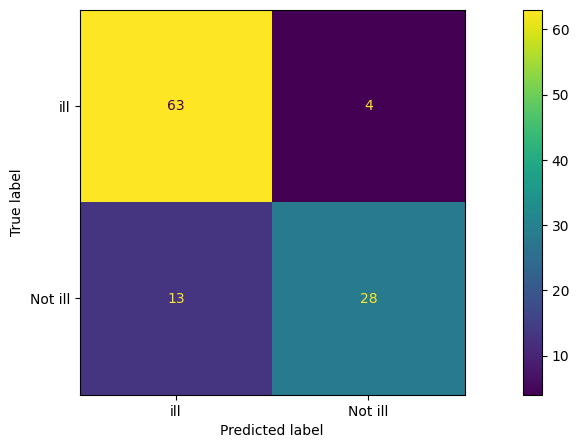


 ####################  Pima Indians, ROS  ####################
Model name:  XGBClassifier
split --  ['Pima Indians', ' ROS']

              precision    recall  f1-score   support

           0      0.882     0.896     0.889        67
           1      0.825     0.805     0.815        41

    accuracy                          0.861       108
   macro avg      0.854     0.850     0.852       108
weighted avg      0.861     0.861     0.861       108



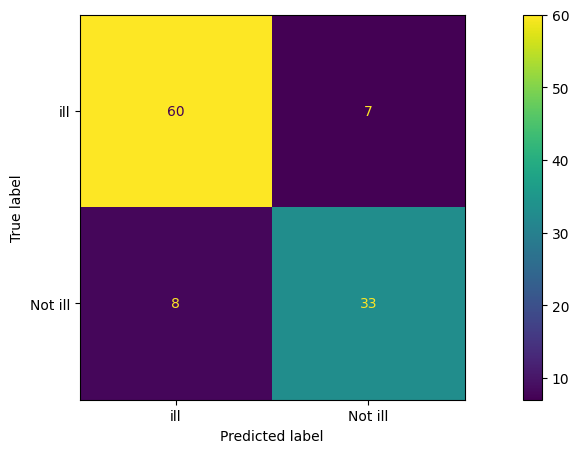


 ####################  Pima Indians, SMOTE  ####################
Model name:  XGBClassifier
split --  ['Pima Indians', ' SMOTE']

              precision    recall  f1-score   support

           0      0.859     0.910     0.884        67
           1      0.838     0.756     0.795        41

    accuracy                          0.852       108
   macro avg      0.848     0.833     0.839       108
weighted avg      0.851     0.852     0.850       108



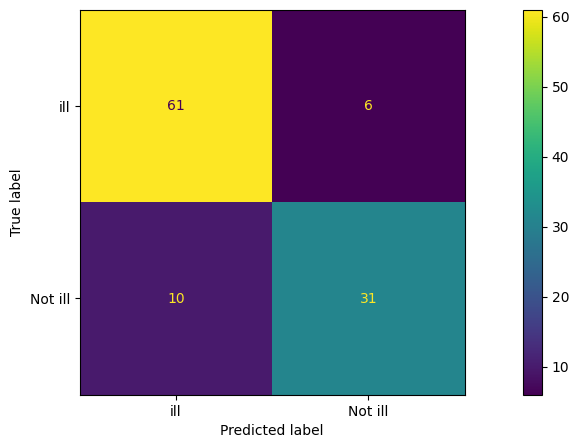


 ####################  Ranchi, Original  ####################
Model name:  DecisionTreeClassifier
split --  ['Ranchi', ' Original']

              precision    recall  f1-score   support

         0.0      0.946     0.976     0.961       126
         1.0      0.941     0.873     0.906        55

    accuracy                          0.945       181
   macro avg      0.944     0.924     0.933       181
weighted avg      0.945     0.945     0.944       181



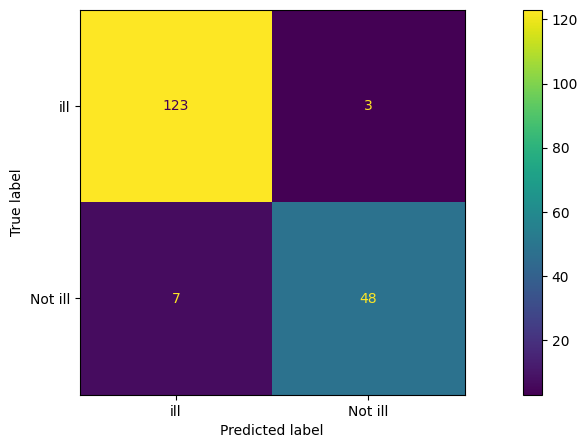


 ####################  Ranchi, ROS  ####################
Model name:  RandomForestClassifier
split --  ['Ranchi', ' ROS']

              precision    recall  f1-score   support

         0.0      0.976     0.960     0.968       126
         1.0      0.912     0.945     0.929        55

    accuracy                          0.956       181
   macro avg      0.944     0.953     0.948       181
weighted avg      0.957     0.956     0.956       181



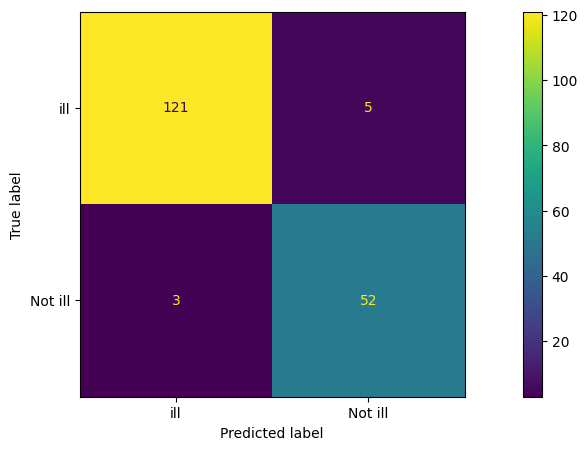


 ####################  Ranchi, SMOTE  ####################
Model name:  XGBClassifier
split --  ['Ranchi', ' SMOTE']

              precision    recall  f1-score   support

         0.0      0.967     0.937     0.952       126
         1.0      0.864     0.927     0.895        55

    accuracy                          0.934       181
   macro avg      0.916     0.932     0.923       181
weighted avg      0.936     0.934     0.934       181



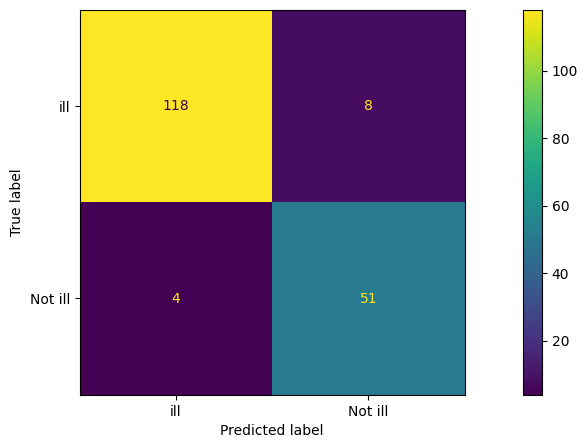


 ####################  Pima Indians, Original  ####################
Model name:  MLPClassifier
split --  ['Pima Indians', ' Original']

              precision    recall  f1-score   support

           0      0.849     0.925     0.886        67
           1      0.857     0.732     0.789        41

    accuracy                          0.852       108
   macro avg      0.853     0.829     0.838       108
weighted avg      0.852     0.852     0.849       108



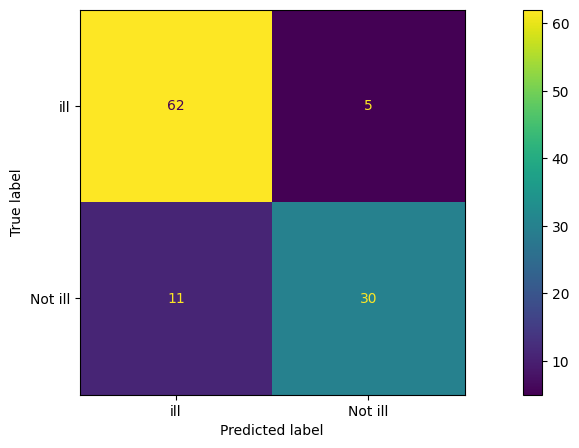


 ####################  Pima Indians, ROS  ####################
Model name:  NN with 2 hidden layers
split --  ['Pima Indians', ' ROS']

              precision    recall  f1-score   support

           0      0.859     0.821     0.840        67
           1      0.727     0.780     0.753        41

    accuracy                          0.806       108
   macro avg      0.793     0.801     0.796       108
weighted avg      0.809     0.806     0.807       108



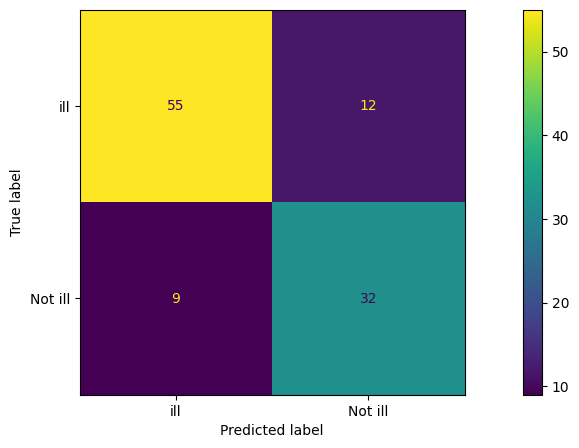


 ####################  Pima Indians, SMOTE  ####################
Model name:  MLPClassifier
split --  ['Pima Indians', ' SMOTE']

              precision    recall  f1-score   support

           0      0.857     0.806     0.831        67
           1      0.711     0.780     0.744        41

    accuracy                          0.796       108
   macro avg      0.784     0.793     0.787       108
weighted avg      0.802     0.796     0.798       108



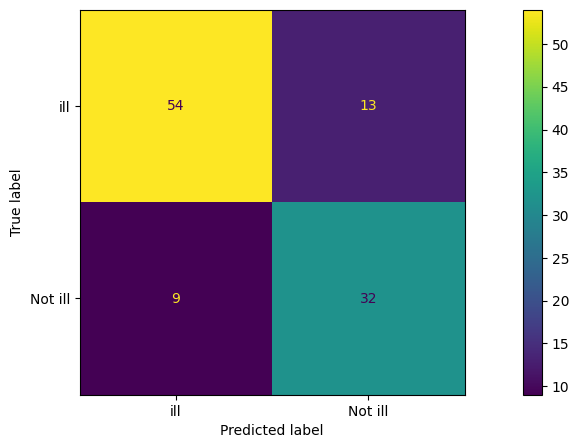


 ####################  Ranchi, Original  ####################
Model name:  NN with 2 hidden layers
split --  ['Ranchi', ' Original']

              precision    recall  f1-score   support

         0.0      0.953     0.960     0.957       126
         1.0      0.907     0.891     0.899        55

    accuracy                          0.939       181
   macro avg      0.930     0.926     0.928       181
weighted avg      0.939     0.939     0.939       181



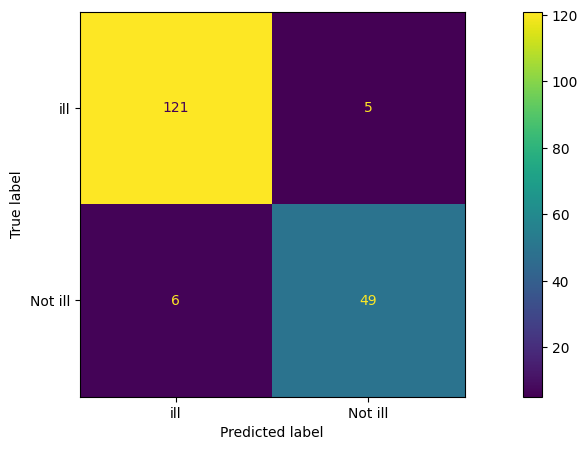


 ####################  Ranchi, ROS  ####################
Model name:  MLPClassifier
split --  ['Ranchi', ' ROS']

              precision    recall  f1-score   support

         0.0      0.952     0.937     0.944       126
         1.0      0.860     0.891     0.875        55

    accuracy                          0.923       181
   macro avg      0.906     0.914     0.909       181
weighted avg      0.924     0.923     0.923       181



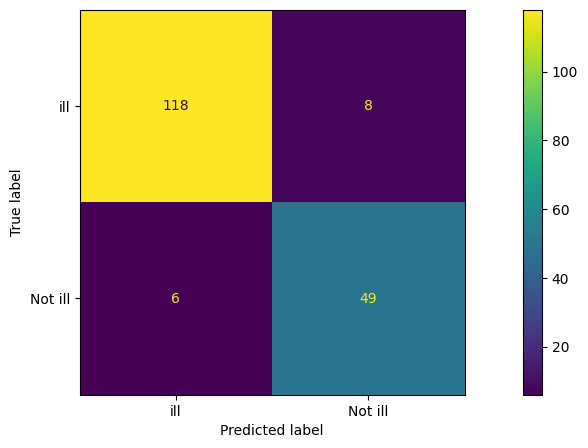


 ####################  Ranchi, SMOTE  ####################
Model name:  MLPClassifier
split --  ['Ranchi', ' SMOTE']

              precision    recall  f1-score   support

         0.0      0.938     0.952     0.945       126
         1.0      0.887     0.855     0.870        55

    accuracy                          0.923       181
   macro avg      0.912     0.903     0.908       181
weighted avg      0.922     0.923     0.922       181



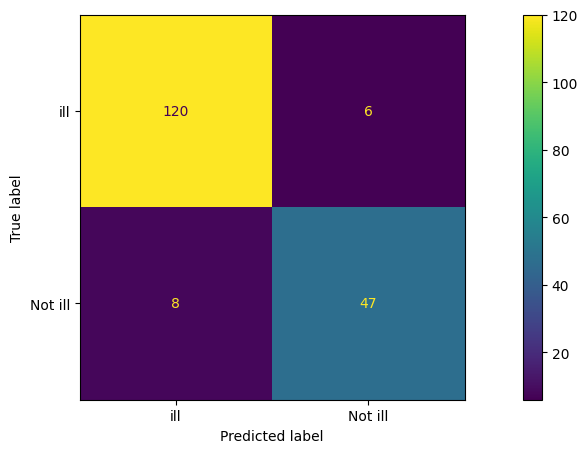

In [45]:
display_models_info(best_results_df)

In [46]:
# tensorflow
# keras==2.2.5
# shap==0.30.0

# !pip install tensorflow
# !pip install keras==2.2.5

### Retrain and save model

In [47]:
# x = pd.concat((X_train, X_test))
# y = pd.concat((y_train, y_test))
# best_model.fit(x, y)
# 
# models_path = "models"
# if not os.path.exists(models_path):
#     os.mkdir(models_path)
# pickle.dump(best_model, open(os.path.join(models_path, "diabet_prediction_model.pkl"), "wb"))